<font color='black' size=10><b><center>Dancing with the Moon</center></b></font>

<font color='blue' size=4><b><center>Learned Uncertainty-Aware (LUNA) Bases for</center></b></font>
<font color='blue' size=4><b><center>Bayesian Regression using Multi-Headed Auxiliary Networks</center></b></font>

<font color='black' size=4><center>Shih-Yi Tseng, Sangyoon Park, Paulina Toro Isaza, Arthur Young, Avriel Epps-Darling<center></font>

## Table of Contents

1. [Problem Statement and Context](#chapter1)

2. [Existing Work](#chapter2)

3. [Contributions](#chapter3)

4. [Technical Content](#chapter4)

5. [Implementation](#chapter5)

6. [Demo: NLM vs. LUNA under Regularization](#chapter6)

7. [Experiments](#chapter7)
    * [7.1 Comparison of Methods](#section_7_1)
    * [7.2 Exploring NLM Behavior](#section_7_2)  
       * [7.2.1 How does regularization affect NLM uncertainty in data-scare regions?](#section_7_2_1)
       * [7.2.2 How consistent is good uncertainty behavior in data-scare regions for NLMs?](#section_7_2_2)
    * [7.3 Exploring LUNA Behavior](#section_7_3)
       * [7.3.1 How does LUNA’s behavior relate to regularization and diversification strengths?](#section_7_3_1)
       * [7.3.2 How does LUNA’s behavior relate to the number of auxiliary functions?](#section_7_3_2)
       * [7.3.3 How does LUNA behave with variation in neural network architecture?](#section_7_3_3)
       * [7.3.4 How does LUNA behave on different gap locations?](#section_7_3_4)
       * [7.3.5 How does LUNA behave on multivariate functions?](#section_7_3_5)

8. [Evaluation](#chapter8)

9. [Broader Impact](#chapter9)

10. [References](#chapter10)

## 1. Problem Statement and Context <a class="anchor" id="chapter1"></a>

While we typically think of model performance in terms of predictive accuracy, many applications would benefit from (and indeed, should require) producing reliable uncertainty measurements. This is particularly true in high-stakes applications where a user should either turn over an uncertain machine-produced decision to a qualified human decison-maker or abstain from using the machine-produced decision altogether. 

Intuitvely, a model should be less certain in data-scarce regions than it is in data-rich regions. Most implementations of popular predictive models do not have an out-of-the-box method to signal to a user that a prediction is being made on data that is out-of-distribution or to quantify the uncertainty due to limited data (also known as epistemic uncertainty). However, generating high model predictive uncertainties in data-scare regions and low predictive uncertainties in data-rich regions is not a trivial task. 

Previous methods for achieving this task are Gaussian Processes (GP), Bayesian Neural Networks (BNNs), and Neural Linear Models (NLM). The first two are not ideal solutions as they are not particularly scalable (GP) or have challenging, intractable inference (BNNs). NLMs are meant to solve these issues by providing tractable inference at scale. For this reason, NLMs have become popular models for applications that require predictive uncertainty.

Despite their popularity, it is not clear from the literature that NLMs produce the desired uncertainty behavior with respect to data-scare and data-rich regions. (See Existing Work for more details.) In "Learned Uncertainty-Aware (LUNA) Bases for Bayesian Regression using Multi-Headed Auxiliary Networks" (Thakur, et. al, 2020), the authors theoretically and empirically investigate the drawbacks of NLMs and propose LUNA, an alternative training procedure, to address these draw backs.

## 2. Existing Work <a class="anchor" id="chapter2"></a>

**Gaussian Processes**

A Gaussian Process (GP) assigns probability distributions not to specific parameters as in traditional Bayesian methods, but to functions (Rasmussen & Williams, 2006). They are particularly useful for producing "good" uncertainty behavior because they support infinite basis functions which lead to high expressiveness. 

Unfortunately, despite producing the desired uncertainty behavior in data-scare regions, GPs are ultimately not practical for most large-scale data applications because they do not scale well as the number of data points increases. This has led researchers to investigate efficient, scalable alternatives.

**Bayesian Neural Networks**

One such alternative is the Bayesian Neural Network (BNN), a neural network whose parameter weights have a prior distribution and thus can produce distributions of predictions instead of simply point-estimates as in traditonal neural networks. (Neal, 1995). These prediction distributions easily translate to model prediction uncertainty. 

However, BNNs are not a practical solution. They do not solve the scalability issue of GPs as gradient-based samplers like HMC are extremely inefficient with large training data. Stochastic implementations of HMC sampling and parallelization can help increase efficiency in relation to training size (Springenber et al., 2016), but that still leaves the challenge of sampling from the complex, multimodal posteiror of neural networks. 

**Neural Linear Models**

A Neural Linear Model is an approximation of GPs in which, instead of placing prior distributions on all the weights as in BNNs, priors are placed on only the weights of the last neural network layer (Snoek et al.,
2015). All other layer weights are point-estimates as in the traditional neural network setting. Essentially, we can think of the deterministic layers as learning a feature map while the last layer performs Bayesian Lienar Regression on the basis of this learned feature map. Restricting prior distributions to only the weights in the last layer allows NLMs to be more tractable than BNNs as there is a closed form analytical expression for the posterior of this last layer.

As mentioned in the problem statement, it is not clear from the literature that NLMs can distinguish between data-scare and data-rich regions and produce the desired uncertainty behaviors for each. One paper claims that a large log-likelihood in the data-scare region signifies high model uncertainty (Ober &
Rasmussen, 2019). This claim does not hold up when we recognize that log-likelihood only accounts for aleatoric uncertainty: that is, uncertainty that comes from the underlying variation in the data generating process (Yao et al., 2019). A good measure of aleatoric uncertainty does not necessarily equate to a good measure of epistemic uncertainty. 

## 3. Contributions <a class="anchor" id="chapter3"></a>

The paper contributes to the literature in two main ways: 
1. Theoretically and empirically determinng that NLMs fail to consistently distinguish between data-scare and data-rich regions when including regularization
2. Proposing an alternative training procedure that consistently distinguishes between data-scare and data-rich regions when including regularization while providing more scalability than GPs and BNNs

The technical details of these contributions are expanded on below. 

## 4. Technical Content <a class="anchor" id="chapter4"></a>

### High Level

The development of LUNA was motivated by the recognition that NLM, a popular Bayesian deep learning architecture with easily interpreted inference properties, generates problematic uncertainty estimates in sparse regions of support using traditional learning methods. The authors address this shortcoming by proposing LUNA as an alternative training procedure, augmenting the objective function with an additional term designed to "diversify" priors at a computational cost equivalent to training one neural-network and one Bayesian linear regression. In short, an NLM can be considered in two parts: the first is a neural network that projects the covariates $\mathbf{x} \in \mathbb{R}^D$ into an embedding called $\phi_{\theta}(\mathbf{x}) \in \mathbb{R}^L$, parameterized by $\theta$. Then, the embedded manifold $\phi_{\theta}$ is passed to a layer of Bayesian linear regression parameterised by $\mathbf{w} \sim \mathcal{N}(0, \alpha \mathbf{I})$ to yield predictions $y$. The model is trained by seeking point estimate values for $\theta$ and then performs inference using the last layer parameterised by $\mathbf{w}$. 

LUNA-based training encourages functional diversity of the feature map $\phi_{\theta}$ learned by the neural network via training $M$ auxiliary linear regressors. The core of LUNA is a two-part objective function:

$$\mathcal{L}_{LUNA}(\Psi) = \mathcal{L}_{Fit}(\Psi) - \lambda \cdot \mathcal{L}_{Diverse}(\Psi)$$

where $\Psi$ includes shared parameters $\theta$ from the neural network and $M$ sets of $\mathbf{w}$ for the auxiliary regressors. The first part, $\mathcal{L}_{Fit}(\Psi)$, represents the log likelihood of $M$ regressors on training data with $L_2$ regularization, whereas the second part, $\mathcal{L}_{Diverse}(\Psi)$, encodes the cosine similarity of the gradients of the $M$ regressors and thus penalizes non-orthogonal gradients. The hyperparameter $\lambda$ represents diversification strength, i.e. how much to prioritize diversity in LUNA training.

After training the NLM with $\mathcal{L}_{LUNA}(\Psi)$ which generates diversified feature basis $\phi_{\theta}$, we toss the auxiliary regressions and perform standard linear Bayesian regression over $\phi_{\theta}(\mathbf{x})$ and analytically compute the posterior of the weights $\mathbf{w}$.

### Details

The first part of LUNA’s objective function is specified as:

$$\mathcal{L}_{Fit}(\Psi) = \frac{1}{M} \sum_{m=1}^M \log\mathcal{N}(\mathbf{y}\,; f_m(\mathbf{x}), \sigma^2\mathbf{I}) - \gamma\|\Psi\|^2_2$$

which is a direct extension of NLM’s maximum a posteriori (MAP) objective. Hence, it attempts to maximize auxiliary regressors’ overall goodness of fit with the observed data while preventing overfitting via $L_2$ regularization.

The second part of LUNA’s objective function is specified as:

$$
\begin{aligned}
\mathcal{L}_{Diverse}(\Psi) 
&= \sum_{i=1}^M \sum_{j=i+1}^M \text{CosSim}^2 \left( \nabla_{\mathbf{x}} f_i(\mathbf{x}), \nabla_{\mathbf{x}} f_j(\mathbf{x}) \right) \\
&= \sum_{i=1}^M \sum_{j=i+1}^M \frac{\left( \nabla_{\mathbf{x}} f_i(\mathbf{x})^T \nabla_{\mathbf{x}} f_j(\mathbf{x}) \right)^2}{\left( \nabla_{\mathbf{x}} f_i(\mathbf{x})^T \nabla_{\mathbf{x}} f_i(\mathbf{x}) \right) \left( \nabla_{\mathbf{x}} f_j(\mathbf{x})^T \nabla_{\mathbf{x}} f_j(\mathbf{x}) \right)}
\end{aligned}
$$

where `CosSim` stands for cosine similarity. Hence, we can see that this diversity objective minimizes when the gradients of auxiliary regressors are all orthogonal to one another, and this orthogonality of auxiliary regressors can be used as a proxy for the diversity of the functions spanned by the feature basis. In practice, we calculate these gradients using a finite difference approximation to avoid expensive computations, i.e. we use:

$$\nabla_{\mathbf{x}} f_i(\mathbf{x}) \approx \frac{f_i(\mathbf{x} + \delta\mathbf{x}) - f_i(\mathbf{x})}{\delta\mathbf{x}}$$

for some small perturbation $\delta\mathbf{x} \sim \mathcal{N}(0,\sigma^2)$ where we generally set $\sigma=0.1$.

## 5. Implementation <a class="anchor" id="chapter5"></a>

For our experiments, we implemented various models used for uncertainty evaluation including GPs, BNNs, NLMs, and ensemble neural networks. 

However, the main implementation work was implementing a working version of LUNA for both single and multi-variate scenarios. 

We decided to implement LUNA as an extension of our general NLM class. As mentioned above, the main differences between LUNA and NLM is the inclusion of auxiliary functions and the loss function $\mathcal{L}_{Diverse}$. Below, we include a code snippet showing this new loss function. To see the full implementation of LUNA along with the implementations of other models, please see source code [here](https://github.com/weyesians/luna-passa/blob/main/src/models.py).

```python
def _make_objective(self, x_train, y_train, reg_param=0, lambda_in=0):
    M = self.params['M']
    N = x_train.shape[1]

    def objective(W_full, t):
        # Compute L_fit
        y_train_rep = np.tile(y_train, reps=(M,1,1)) # repeat y_train with shape = dim_out x n_sample to M x dim_out x n_sample
        squared_error = np.linalg.norm(y_train_rep - self.forward(W_full, x_train), axis=1)**2
        L_fit = np.mean(squared_error) + reg_param * (np.linalg.norm(W_full)**2) / W_full.size

        # Comput L_diverse (#### Only works for dim_out = 1 ####)
        if self.params['dim_in'] == 1:
            grad_FD = self._finite_diff_grad(W_full, x_train) # reshape to M x num of samples
            grad_angle = np.arctan(grad_FD) # compute the "angle of those gradients"
            grad_angle_rep = np.tile(grad_angle, reps=(M,1,1)) # repeate the matrix to create M x M x num of samples
            grad_angle_rep_transpose = np.transpose(grad_angle_rep, axes=(1,0,2)) # transpose the M x M matrix so we can take pairwise differences between auxiliary functions
            coSimSqMat = np.mean(np.cos(grad_angle_rep - grad_angle_rep_transpose)**2, axis=-1) # take pairwise square cosine similarity between auxiliary functions, average over datapoints
        else:
            grad_FD = self._finite_diff_grad(W_full, x_train) # M x dim_in x num of samples
            norm_grad = grad_FD/(np.linalg.norm(grad_FD, axis=1).reshape((M,1,N))) # normalize along gradient wrt dim_in to unit length (so inner product gives cosine value directly)
            norm_grad_transpose = np.transpose(norm_grad, axes=(1,0,2)) # transpose first two dimensions of norm_grad (for taking pairwise inner product in next step)
            coSimSqMat = np.mean(np.einsum('ij...,jk...->ik...', norm_grad, norm_grad_transpose)**2, axis=-1) # take pairwise square cosine similarity between auxiliary functions (broadcasting along datapoint dimension), and then average over datapoints
            #### See documentation for np.einsum (with broadcasting): https://numpy.org/doc/stable/reference/generated/numpy.einsum.html#numpy.einsum

        coSimSq_uniq_pair = coSimSqMat[np.triu(np.ones((M,M), dtype=bool), k=1)] # taking the upper triagular part
        L_diverse = np.mean(coSimSq_uniq_pair)

        return L_fit + lambda_in * L_diverse  # punish when coSimSq is large (close to 1)

    return objective, grad(objective)
```

In the following section, we demonstrate how to use our implementations of NLM and LUNA through a simple pedagogical example.

*Note: Training may take a long time, so we recommend NOT running it yourself unless you need to.*

## 6. Demo: NLM vs. LUNA under Regularization <a class="anchor" id="chapter6"></a>

The paper argues that the main problem with NLMs is that they are unable to express the desired uncertainty behavior in data-scare regions when using regularization. LUNA was set out to remedy this limitation by using a diversified feature map. Below, we walk through generating two sets of NLM and LUNA, one with no regularization and the other with regularization, on the same cubic gap toy dataset.

First, we generate the toy data and setup the NLM and LUNA architecture. All models share the same architecture, and the only difference is the regularization strength.

In [ ]:
from src.models import NLM, LUNA
from src.utils import generate_data, format_time, neg_log_likelihood, epistemic_uncertainty
from autograd import numpy as np
import matplotlib.pyplot as plt

# Generate toy data
x, y, x_test, y_test = generate_data(number_of_points=50, noise_variance=9)

# Extract test gap data
gap_idx = np.logical_and(x_test > -2, x_test < 2)
x_test_gap = x_test[gap_idx].reshape(1,-1)
y_test_gap = y_test[gap_idx].reshape(1,-1)

# Extract test non-gap data
non_gap_idx = np.logical_or(np.logical_and(x_test > -4, x_test < -2),np.logical_and(x_test > 2, x_test < 4))
x_test_non_gap = x_test[non_gap_idx].reshape(1,-1)
y_test_non_gap = y_test[non_gap_idx].reshape(1,-1)

# Define model architecture to use
architecture = {
    'width': [50,50],
    'input_dim': 1,
    'output_dim': 1,
    'activation_fn_type': 'relu',
    'activation_fn_params': 'rate=1',
    'activation_fn': lambda x: np.maximum(np.zeros(x.shape), x),
    'auxiliary_functions': 30, # Used by LUNA
}

# Set random state to make the experiments replicable
rand_state = 207
random = np.random.RandomState(rand_state)

# Define design choices in gradient descent
params = {
    'step_size': 1e-2,
     'max_iteration': 10000,
    'random_restarts': 1,
    'reg_param': 100,
    'lambda_in': 100, # Diversification strength
}

# Set hyperparameter values for inference later
prior_var = 9
noise_var = 9

We then train two sets of models, one with `regularization = 0` and the other with `regularization = 100`.

In [ ]:
nlm_list = []
luna_list = []
reg_grid = [0, 100]

for reg in reg_grid:

    print(f"\n===== NLM (REG={reg}) =====")
    nlm = NLM(architecture, random=random)
    nlm.modtype = 'NLM'
    nlm.reg = params['reg_param'] = reg
    nlm.fit(x, y, params)
    nlm_list.append(nlm)
    
    print(f"\n===== LUNA (REG={reg}) =====")
    luna = LUNA(architecture, random=random)
    luna.modtype = 'LUNA'
    luna.reg = params['reg_param'] = reg
    luna.fit(x, y, params)
    luna_list.append(luna)


===== NLM (REG=0) =====
Iteration 0 loss 8528.227060221521; gradient mag: 19598.254854870906
Iteration 100 loss 84.49891870185589; gradient mag: 67.34066308198605
Iteration 200 loss 23.804832498265508; gradient mag: 34.36073329179997
Iteration 300 loss 12.418929611269178; gradient mag: 7.8218258203317514
Iteration 400 loss 10.833654191403163; gradient mag: 2.603156060823849
Iteration 500 loss 10.565464009747789; gradient mag: 2.632838821656602
Iteration 600 loss 10.522010012687586; gradient mag: 3.468157468040252
Iteration 700 loss 10.514785998102338; gradient mag: 1.0840878651546675
Iteration 800 loss 10.513083020485986; gradient mag: 1.7432762192455329
Iteration 900 loss 10.512718093410115; gradient mag: 2.216655357850456
Iteration 1000 loss 10.512281893348105; gradient mag: 2.3291578455178
Iteration 1100 loss 10.51197817744762; gradient mag: 1.9205608390549807
Iteration 1200 loss 10.511787318890566; gradient mag: 4.706958056203429
Iteration 1300 loss 10.511204686453416; gradient ma

Iteration 1400 loss 115.85103079382549; gradient mag: 76.99504112237258
Iteration 1500 loss 116.36462832894799; gradient mag: 53.05442716198619
Iteration 1600 loss 116.54860086189703; gradient mag: 89.14416858128315
Iteration 1700 loss 115.2544641958385; gradient mag: 26.005106933065466
Iteration 1800 loss 115.29431110525897; gradient mag: 68.03997109107125
Iteration 1900 loss 115.17412301565841; gradient mag: 41.645413739744605
Iteration 2000 loss 130.9704784195348; gradient mag: 167.6097434201943
Iteration 2100 loss 116.30792643811873; gradient mag: 121.72791372254919
Iteration 2200 loss 116.15843696044064; gradient mag: 42.33976729619227
Iteration 2300 loss 116.02256721703736; gradient mag: 31.174172163558833
Iteration 2400 loss 115.27831988823525; gradient mag: 38.051410638351406
Iteration 2500 loss 115.33389376402945; gradient mag: 43.98933785300733
Iteration 2600 loss 116.08392327337188; gradient mag: 51.395357878967204
Iteration 2700 loss 115.5760372748519; gradient mag: 75.7549

Iteration 2800 loss 23.18245512442622; gradient mag: 13.737362785154874
Iteration 2900 loss 22.626954672462418; gradient mag: 30.940631781820677
Iteration 3000 loss 22.064822171016885; gradient mag: 34.404058070315145
Iteration 3100 loss 21.46223525808792; gradient mag: 8.391498766189924
Iteration 3200 loss 20.980432698724186; gradient mag: 22.482702867795037
Iteration 3300 loss 20.4835866011745; gradient mag: 15.879055626791653
Iteration 3400 loss 20.02068232753516; gradient mag: 7.078060467985345
Iteration 3500 loss 19.607768863468888; gradient mag: 6.432024184319297
Iteration 3600 loss 19.209934940076835; gradient mag: 2.944516250824781
Iteration 3700 loss 18.856634495236648; gradient mag: 14.146385953646972
Iteration 3800 loss 18.50005355874545; gradient mag: 7.8988912665136155
Iteration 3900 loss 18.184866250997587; gradient mag: 8.73724657774567
Iteration 4000 loss 17.883615166285963; gradient mag: 10.899100397350308
Iteration 4100 loss 17.596218826310874; gradient mag: 6.5961796

Iteration 4200 loss 128.2049522310574; gradient mag: 6.018305678048377
Iteration 4300 loss 127.45928512368388; gradient mag: 31.598663938746622
Iteration 4400 loss 126.39072914725261; gradient mag: 8.305296307029101
Iteration 4500 loss 126.27056369447823; gradient mag: 24.463666173025047
Iteration 4600 loss 125.60720016094598; gradient mag: 8.11325655310735
Iteration 4700 loss 128.21782008343115; gradient mag: 32.45591387572219
Iteration 4800 loss 125.17733538177453; gradient mag: 8.08005635283857
Iteration 4900 loss 124.98990540166358; gradient mag: 14.26782565606797
Iteration 5000 loss 125.33696648424916; gradient mag: 25.413989490914805
Iteration 5100 loss 124.51507067314482; gradient mag: 65.30789161301672
Iteration 5200 loss 125.07656703905876; gradient mag: 12.042129892959267
Iteration 5300 loss 124.22733342372717; gradient mag: 16.60800829656219
Iteration 5400 loss 124.3887028905702; gradient mag: 13.320760553929087
Iteration 5500 loss 123.65021184369708; gradient mag: 7.2173478

Let's visualize the prior samples:

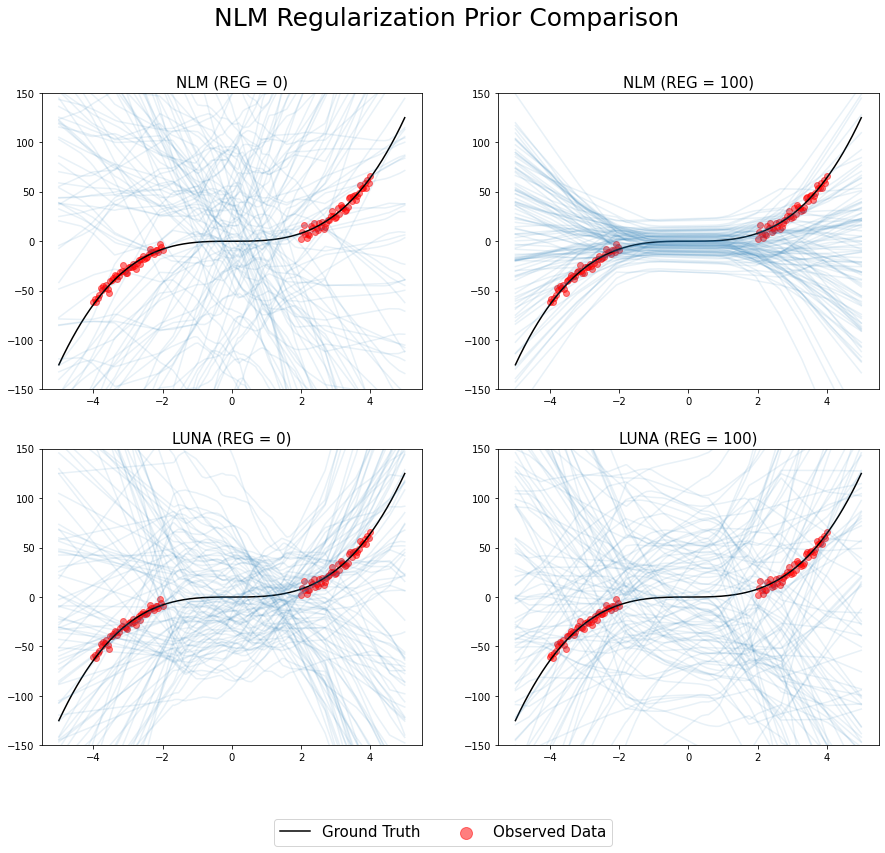

In [ ]:
mod_list = nlm_list + luna_list

fig, axs = plt.subplots(2, 2, figsize = (15, 12))
for i, ax in enumerate(axs.ravel()):
    mod = mod_list[i]
    y_prior = mod.get_prior_preds(x_test, w_prior_mean=0, w_prior_cov=prior_var, noise_var=noise_var)
    ax.scatter(x,y, color='red', alpha=0.5, label='Observed Data')
    ax.plot(x_test[0,:], y_test[0,:], color='black', label='Ground Truth')
    ax.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
    ax.set_ylim([-150, 150])
    ax.set_title(f'{mod.modtype} (REG = {mod.reg})', fontsize=15)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=15, markerscale=2)
plt.suptitle("NLM Regularization Prior Comparison", fontsize=25)
plt.show()

In the plots above, we recreated the example given in the paper showing that NLMs with no regularization can produce expressive prior samples but regularization results in far less expressive prior samples, particularly in the data-scare region of the gap. In contrast, we can observe that regularization in LUNA does not adversely affect its expressiveness in the prior samples.

*Note that in our implementation, we normalized each term in the loss function: log likelihood was normalized by the number of datapoints times the number of auxiliary functions, regularization was normalized by the number of neural network weights, and cosine similarity was normalized by the number of pairs of auxiliary functions x the number of datapoints. This normalization may make the magnitude of the hyperparameters different from the examples in the original paper, but we found the normalization useful to compare effects of hyperparameters across different experiments involving chnages in architecture, auxiliary functions and dataset size.*

Now, let's take a look at the posterior predictive:

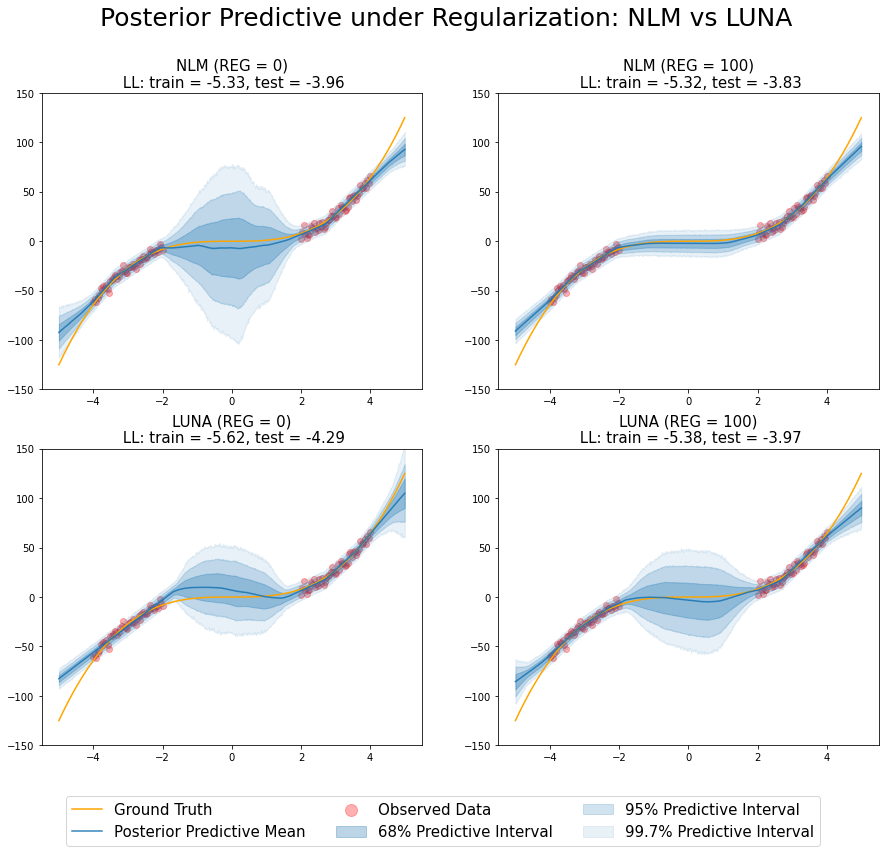

In [ ]:
mod_list = nlm_list + luna_list
lls_train = []
lls_test = []

fig, axs = plt.subplots(2, 2, figsize = (15, 12))
for i, ax in enumerate(axs.ravel()):
    mod = mod_list[i]

    # Calculate Posteriors
    y_posterior = mod.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
    y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size=y_posterior.shape)
    posterior_predictive_train = mod.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
    posterior_predictive_train = posterior_predictive_train + np.random.normal(0, noise_var**0.5, size=posterior_predictive_train.shape)
    posterior_predictive_non_gap = mod.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
    posterior_predictive_non_gap = posterior_predictive_non_gap + np.random.normal(0, noise_var**0.5, size=posterior_predictive_non_gap.shape)

    # Calculate Log-Likelihoods
    lls_train.append(neg_log_likelihood(posterior_predictive_train, y, noise_var) * -1)
    lls_test.append(neg_log_likelihood(posterior_predictive_non_gap, y_test_non_gap, noise_var) * -1)

    # Calculating Percentiles
    pp_upper = np.percentile(y_posterior, 97.5, axis=0)
    pp_lower = np.percentile(y_posterior, 2.5, axis=0)
    pp_upper2 = np.percentile(y_posterior, 84, axis=0)
    pp_lower2 = np.percentile(y_posterior, 16, axis=0)
    pp_upper3 = np.percentile(y_posterior, 99.85, axis=0)
    pp_lower3 = np.percentile(y_posterior, 0.15, axis=0)
    pp_mean = np.mean(y_posterior, axis=0)

    # Visualizing 68%/95%/99.7% posterior predictive interval of Bayesian polynomial regression
    ax.scatter(x[0,:], y[0,:], color='red', alpha=0.3, label='Observed Data')
    ax.plot(x_test[0,:], y_test[0,:], color='orange', label="Ground Truth")
    ax.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
    ax.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label="68% Predictive Interval")
    ax.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label="95% Predictive Interval")
    ax.fill_between(x_test[0,:], pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1, label="99.7% Predictive Interval")
    ax.set_ylim([-150, 150])
    ax.set_title("{:} (REG = {:.0f})\n LL: train = {:.2f}, test = {:.2f}".format(mod.modtype, mod.reg, lls_train[i], lls_test[i]), fontsize=15)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=15, markerscale=2)
plt.suptitle("Posterior Predictive under Regularization: NLM vs LUNA", fontsize=25)
plt.show()

We observe that the NLM with no regularization is able to express the desired uncertainty in the data-scare region but that the NLM with regularization expresses insufficient uncertainty in the data-scare region. Again, this contrasts with LUNA, where regularization does not "collapse" the uncertainty in the data-scare region.

The log likelihood values of the models demonstrate that log likehiood cannot be used as a measure of the quality of the uncertainty in this gap region. In other words, a lower (or higher) log likehiood does not automatically indicate a better quality of epistemic uncertainty.

## 7. Experiments <a class="anchor" id="chapter7"></a>

### 7.1 Comparison of Methods: 1-D Cubic Gap <a class="anchor" id="section_7_1"></a>

As in the paper, we ran various baseline models and LUNA on the 1-D cubic gap toy dataset. You can see the full experiment along with architecture and hyperparmeter choices [here](https://github.com/weyesians/luna-passa/blob/main/notebooks/comparison_of_methods.ipynb).

<img src = "images/method_comparisons.png" />

As expected, the gold standards of BNN and GP produced the best epistemic uncertainty behavior in the gap region. Meanwhile, MAP was unable to produce any espistemic uncertainty in either data-scare or data-rich regions. Our ensemble bootstrap and NLM produced somewhat higher epistemic uncertainty in the gap region compared to the data-rich region, but such uncertainty was severly underestimated compared to BNN and GP. Finally, while LUNA was not able to perform as well as BNN and GP, it did produce the closest uncertainty behavior to the gold standard methods. 

We also timed each of the methods to showcase the need for LUNA in place of the gold standard models. 

<img src = "images/method_runtimes.png" />

This comparison is not perfectly generalizable for real world data which has much higher dimensions and more data points. Particularly, GPs have a cubic time complexity (O($n^3$) depending on the number of data points $n$. Thus, while it ran in less than our second for our toy data, it is actually expected to scale far worse than the other methods. Despite this, we still found the other runtimes to be illustrative. The BNN model took almost twice as long to run as LUNA. Meanwhile, LUNA ran in comparable time to NLM. 

### 7.2 Exploring NLM Behavior <a class="anchor" id="section_7_2"></a>

You can find the following NLM experiments [here](https://github.com/weyesians/luna-passa/blob/main/notebooks/experiment_NLM.ipynb).

#### **7.2.1 How does regularization affect NLM uncertainty in data-scare regions?** <a class="anchor" id="section_7_2_1"></a>

Our first experiment investigates at which regularization level our good uncertainty beahvior "collapses": that is, when the uncertainty in the data-scare region is mimics the uncertainty in the data-rich region.

Because our regularization is normalized by the number of data points, our regularization parameters are on a larger scale than that of the paper. For this reason, we first tested parameters between 0 and 1000.

<img src = "images/nlm_reg_0_1000.png">

As seen in the graph above, uncertainty in the gap region collapses somewhere between regularization = 10 and regularization = 100.

<img src = "images/nlm_reg_20_70.png">

Upon further inspection, this appears to happen after regularization = 50. 

However, we need to remember that NLM does not give us consistent uncertainty behavior in the gap region. This brings us to our next experiment. 

#### **7.2.2 How consistent is good uncertainty behavior in data-scare regions for NLMs?** <a class="anchor" id="section_7_2_2"></a>

In our extended experiments, we noticed that our NLMs were performing much more consistently than expected from the paper findings. In particular, NLMs with no regularization were always giving greater uncertainty in the data-scare region than in the data-poor region. As regularization went up, this behavior became more and more inconsistent. 

We can explain the departure from the paper results from the fact that we are using a prior variance of 9 while the paper used a prior variance of 1. 

<img src = "images/nlm_random_state_prior_var.png">

We see that prior variance greatly affects the uncertainty behavior in the data-scare region. The paper claims that NLM inconsistently gives good uncertainty behavior, but this might be only true for lower prior variances. Thus, LUNA might be more suitable than NLMs in cases where we want our prior variance to be small. A hypothesis to test in future work is whether or not NLMs in scenarios with larger prior variances are sufficient for good uncertainty behavior in data-scare regions. 

### 7.3 Exploring LUNA Behavior <a class="anchor" id="section_7_3"></a>

#### **7.3.1 How does LUNA’s behavior relate to regularization and diversification strengths?** <a class="anchor" id="section_7_3_1"></a>

We implemented LUNA and tested it on the 1-D the cubic gap dataset. We used a 2-layer MLE with 50 units per layer and 30 auxiliary functions. For Bayesian linear regression, both prior variance and noise variance were set at 9. To study the behavior of LUNA, we performed a grid search on regularization ($Reg = \left \{ 0, 10, 30, 100, 300, 1000, 3000 \right \}$) and diversitifcation ($Div = \left \{ 0, 10, 100, 1000, 10000 \right \}$). We minimized the LUNA loss function with Adam optimizor (step size =  $10^{−2}$, 5000 steps), and compared the results to NLM with the same architecture and regularization and optimization hyperparameters. The details of the experiment can be found [here](https://github.com/weyesians/luna-passa/blob/main/notebooks/LUNA_grid_search_of_regularization_and_diversification_demo.ipynb).

First we inpected the behavior of the auxiliary functions, visualized below:

<img src="./images/aux_funcs_30_aux_5000_steps-2.png" width="1000">

We observed two trends:

1. With a fixed diviersification value, we can see that auxiliary functions appeared to be more diverse with low regularization, whereas higher regularization puhsed all auxiliary functions to be flat with small slopes, as expected by the effect of regularization.

2. With a fixed regularization value (more obvious with smaller regularization), as the diversification value increased, we first observe increased diversity of the auxiliary functions in the gap region, whereas in the data-rich regions, these auxiliary functions still consistently pass through the training points in a homogenous manner, with less diversity. However, as diversification value further increased ($Div \geq  100$), we started to see the auxiliary function ssplit into two groups. One group still tried to go linearly through the training points, where the other group became horizontal and passed through the mean y value of the training points in that region. This was originally very perplexing, but became sensible after we gave it a second thought since 
   - The $L_{diverse}$ in the LUNA loss function enforced cosine similarity between the gradients of pairs of auxiliary functions at each datapoints to be small (large angles).
   - The likelihood part of $L_{fit}$ tried to pull the auxiliary functions to be closed to datapoints. Putting the value at mean would make sure square error doesn't blow up.
   - At the same time, the regularization part of $L_{fit}$ prohibited auxiliary functions to wiggle drastically between training points (this can be a way to create small cosine similarity), so a quasi-linear behavior is enforced.
   
The interplay of these three terms in the $L_{LUNA}$ thus generated this interesting behavior of the auxiliary functions, suggesting that having multiple terms in loss functions for different purposes can lead to complex, sometimes counter-intuitive behavior.

Never the less, the diversity created by the auxiliary functions was able to generate desirable epistemic uncertainty in the posterior predictive. Below we plot the posterior predictive intervals of the results after linear Bayesian regression, for both NLM and LUNA. 

<img src="./images/PPI_NLM_30_aux_5000_steps-2.png" width="1000">

<img src="./images/PPI_LUNA_30_aux_5000_steps-2.png" width="1000">

As we can see, when we increased the regularization for NLM, the epistemic uncertainty in the gap region collapsed rapidly. But with LUNA, we were able to restore the desirable epistemic uncertainty in the gap region. However, we also observed a trade-off between the epistemic uncertainty in the gap region and model fit (log likelihood) in the data-rich region. When the diversitication value is really high, the posterior samples in the data-rich region become very rigid and stop fitting to the curve. This can be explained by the "linear" and "crossing" behavior of the auxiliary functions under high diversitfication.

We evaluated our results by computing the log likelihood on training and non-gap test data, as well as the epistemic uncertainty on the gap test data and non-gap test data. The results are summarized in the plot below. In short, NLM and LUNA with low to intermediate values of diversification showed similarly high test log likelihood for most of the regularization values (except for the highest one), but LUNA significantly boosted the epistemic uncertainty in the gap region.


<img src="./images/evaluation_30_aux_5000_steps-2.png" width="800">

Finally, we can take a closer look at the prior and posterior samples of NLM and LUNA. We selected the best performing NLM by log likelihood on non-gap test data ($Reg = 300$), and picked a corresponding LUNA with comparable test log likelihood but decent epistemic uncertainty ($Div = 100$). The prior samples for NLM did not seem diverse compared to the ones from LUNA, leading to reduced epistemic uncertainty in the gap region. The prior samples of LUNA appeared to fill the space more evenly and formed diverse bases for Bayesian linear regression that support large epistemic uncetainty in the data-scarce region.


<img src="./images/LUNA_NLM_comparison.png" width="900">

#### **7.3.2 How does LUNA’s behavior relate to the number of auxiliary functions?** <a class="anchor" id="section_7_3_2"></a>

Another important hyperparameter in LUNA is the number of auxiliary functions. In order to examine how it relates to LUNA’s behavior, we performed another grid-search experiment where we varied diversification strength ($Div = \left\{ 0, 10, 100, 1000, 10000 \right\}$) and the number of auxiliary functions ($Aux = \left\{ 3, 5, 10, 30, 50 \right\}$) while fixing regularization strength ($Reg = 600$). Otherwise, the experiment setup was identical to the earlier one. The details of the experiment can be found [here](https://github.com/weyesians/luna-passa/blob/main/notebooks/LUNA_grid_search_of_auxnum_and_diversification.ipynb).

Results suggest that, even with a small number of auxiliary functions, we can obtain considerably large epistemic uncertainty *if* diversification strength is large enough (relative to regularization strength). However, large diversification strength pushes auxiliary functions “away” from one another (to make their gradients orthogonal), which results in poorer fit with the observed data (i.e. lower log likelihood).

Increase in the number of auxiliary functions seems to ameliorate this tradeoff between model fit and epistemic uncertainty: by increasing the number of auxiliary functions, we can achieve ideal epistemic uncertainty at much *lower* diversification strength, which means less sacrifice of model fit with the observed data. However, LUNA with more auxiliary functions takes longer to train, so there is a different type of tradeoff.

<img src="./images/PPI_LUNA_reg600_steps5000.png" width="1000">

In sum, LUNA helps to overcome the “collapse” of epistemic uncertainty (under regularization) by using a diversified feature basis. This, however, comes at the cost of model fit: greater diversification, although achieving ideal epistemic uncertainty despite regularization, deteriorates the model’s overall fit with the observed data. This can be in turn overcome by using more auxiliary functions at weaker diversification, but it incurs longer training time.

#### **7.3.3 How does LUNA behave with variation in neural network architecture?** <a class="anchor" id="section_7_3_3"></a>

One aspect of LUNA model design that lacks documentation in the original paper is the impact of architectural variation on the epistemic uncertainty featured in a learned model. The following section considers the impact of this set of design choices on the resultant inference properties. You can find the full suite of experiments [here](https://github.com/weyesians/luna-passa/blob/main/notebooks/LUNA_architecture_plots.ipynb).  

We begin by taking a base case against which we will compare the results of all our architecture variation. Following successful results with a LUNA training architecture detailed in table below, we conducted additional experimentation by varying the architecture from this case.

| parameter description             | parameter value                      |
| --------------------------------- | -----------------------------------  |
| input dimension                   | $ D_{in} =  1$                       |
| output dimension                   | $ D_{out} =  1$                       |
| regularization weighting          | $\mu = 100.0$                        |
| cosimilarity weighting            | $\lambda = 100.0$                    | 
| Hidden Layers                     | $\textrm{depth} = 2$                 |
| Width (of each hidden layer)      | $\mathbf{W} = \{50, 50\} $           | 
| auxilliary regressors             | $M = 30$                             | 
| maximum iterations                | 5000                                 | 
| activation function               | ReLu                                 | 
| step size                         | 1e-2                                 | 

Our inquiry into the effects of architecture on inference properties can be divided into four main categories:

* width (nodes per layer)
* depth (layers in network)
* increasing vs. decreasing width
* width relative to number of auxiliary regressors ($L$ vs.$M$ )


The following subsections address each of these considerations in turn.

**Effect of width on LUNA inference properties**

In simple terms, increasing the width of the hidden layer components of an NLM/LUNA model adds complexity to the model which we can expect to increase the expressiveness of our posterior predictions at the cost of training runtime. Our foremost concern when it comes to increasing our model width is the dimensionality of our \textit{last} hidden layer and therefore the dimensionality of feature map $\Phi_{\theta}$. Suppose we represent the entirety of the NLM/LUNA model as follows:

\begin{align}
    \underbrace{\mathbf{X} \otimes H^{\omega_1}_{\theta_1} \otimes H^{\omega_2}_{\theta_2} \otimes ... \otimes H^{\omega_D}_{\theta_D}}_{\Phi_{\theta}} \otimes \mathbf{W} = \mathbf{y}
\end{align}


where $H$ denotes a hidden layer, $D$ denotes the depth of the model, $\omega$ denotes the width of the relevant hidden layer, and $\theta$ refers to the set of parameters $\{ \theta_1, \theta_2, ..., \theta_D \} $ that parameterise the feature map. The dimensions of the feature map are $N \times L$, where $N$ denotes number of observations of $\mathbf{X, y}$ and $L = \omega_D$ denotes the dimensions of the feature map space. An increase in the width of $H_{\theta_D}$ has the undesired effect of increasing the dimensionality of the auxiliary regressors $W \in \mathbb{R}^{M \times L}$, and so we can expect training time to increase for a fixed number $M$ auxiliary regressors with an increase in $L$. Despite this, we cannot cast aside the notion of increasing the width of our network, because we fully expect that the expressiveness of our posterior predictions will vary greatly with increase in the width of $H_{\theta_D}$. Below, we provide the results for the uniform variation in width of a two layer feature mapping from $\omega_1 = \omega_2 = \omega \in [25, 200]$:

<img src="./images/Width_plots.png" width="1000">

| plot coordinate | [1, 1]    | [1, 2]    | [2, 1]    | [2, 2]    |   
| --------------- | --------- | --------- | --------- | --------- |   
| $\omega$ | [25, 25] | [50, 50] | [100, 100] | [200, 200] |   
| runtimes (s) | 94 | 547 | 310 | 924 |   
| param num | 1480 | 4130 | 13330 | 46630 |   
| mean epistemic variance | 17.11 | 99.04 | 221.72 |  934.60 | 




Overall our plots unsurprisingly show that with increase in width $\omega$, our epistemic uncertainty in the gap and extremum regions of the support increases in magnitude.


With increase in the width, we observe the emergence of harmonic behavior in the posterior predictions within the gap region. The frequency of the oscillatory behavior seems to increase as $\omega$ increases, with $\omega = 50$ appearing to exhibit a single mode waveform. 

We note that $\omega = 50 $ is our base case, and perhaps it embodies the fundemental frequency of the observed oscillatory behavior because of the specific set of training parameters we have fixed and declared in the table above.

**Effect of depth on LUNA inference properties**

While increase in width comes at a cost of training time due to the resultant dimensions of the auxilliary regressors, a viable alternative presents itself by increasing the depth of our neural network, i.e. increasing the value of $D$. If $D$ is sufficiently large so that our posterior predictions are expressive but the last hidden layer $H^{\omega_D}_{\theta_D}$ is thin, then $W$ will also be thin. In other words, if we may achieve high posterior predictive diversity using a deep network of thin hidden layers rather than a wide, shallow network, then it stands to reason that our training time will be faster with no loss in inference quality. Below, we give results for neural networks of width 50 with $D \in [1, 5]$:

<img src="./images/Depth_plots.png" width="1000">

| plot coordinate | [1, 1] | [1, 2] | [2, 1] | [2, 2] | [3, 1] | [3, 2] | 
| ------ | ------ | ------ | ------ | ------ | ------ | ------ | 
| $\omega$ | [50] | [50, 50] | [50, 50, 50] | [50, 50, 50, 50] | [50, 50, 50, 50, 50] | [25, 25, 25, 25] |       
| runtimes (s) | 193 | 547 | 188 | 241 | 306 | 510 |  
| param num | 1630 | 4180 | 6730 | 9280 | 11830 | 2780 |     
mean epistemic variance | 2.30 | 99.04 | 656.22 | 92548.82 | 124375.41 | 297.48 |

To no suprise, the increase in model depth has a direct relationship with epistemic uncertainty. We see that for additional hidden layers of width $\omega = 50$, there is dramatic amplification in the variance of the psoterior predictions in the OOD regions. 

We have also included the results for a 4 layer network of uniform width $\omega = 25$ to compare to the base case of two layers with width $\omega = 50$. For the same number of parameters, and indeed lower dimensional auxilliary parameters, the epistemic uncertainty is greater for this thinner, deeper network. 

We note that in general, our deep networks suffer from slower convergence rates. For virtually all of our tested systems trained over 5000 iterations of gradient descent, the ratio of the final loss value to the previous iteration's is roughly 99%. However, for our deepest networks this ratio is closer to 20%. For our deep neural networks, we recommend that a higher training rate should be applied, or a more sophisticated learning schedule must be utilized.

**Effect of increasing vs. decreasing width on LUNA inference properties**

Until this point, all given results were for neural network architectures of uniform width for all layers. We have found that increase in width adds to training time, but that increase in depth hinders convergence, though both seem to give us control over the behavior of our posterior predictive epistemic uncertainty. In principle, it may not be necessary to have many wide hidden layers when a few hidden layers with width varying appropriately will do the trick. Ultimately, in the interest of efficiency, we are hoping that having a network that diminishes in width will yield good results, since we would like to improve the efficiency of our training regime by pursuing low dimensional auxilliary regressors. Below, we give results for three layer neural networks of various widths:

<img src="./images/Vary_plots.png" width="1000">

| plot coordinate | [1, 1] | [1, 2] | [1, 3] | [2, 1] | [2, 2] | [2, 3] | 
| ------ | ------ | ------ | ------ | ------ | ------ | ------ | 
| $\omega$ | [25, 50, 100] | [100, 50, 25] | [200, 100, 50] | [100, 100, 25] | [100, 100, 50] | [100, 50, 50] |       
| runtimes (s) | 803 | 657 | 2012 | 1075 | 1309 | 755 |  
| param num | 9430 | 7305 | 27080 | 9280 | 16880 | 9330 |  
| mean epistemic variance | 1459.63 | 1503.49 | 12350.91 | 1649.04 | 1150.29 | 724.09 | 

Our hope that thin final hidden layers would also yield desirable inference properties appears to be in vain. The above figures portraying the inference results from variable width three layer neural networks contrast the behavior of "thinning" vs. "widening" or "converging" vs. "diverging" architecture schemes. 

The top left plot is our only "diverging" network, with architecture $\{ \omega_1, \omega_2, \omega_3 \} = \{25, 50, 100\}$. While the observed epistemic uncertainty is too high, it is the shape we are concerned with, and overall has a desirable form. 

The subsequent plots are all of "converging" networks, and in particular, the middle plot in the top row is a "mirror" of the architecture applied for the sole diverging network, with an architecture of $\{ \omega_1, \omega_2, \omega_3 \} = \{ 100, 50, 25 \}$. Immediately, it becomes clear that where the widening network exhibits generally homogenous distribution of posterior predictions, the thinning architecture has a clearly harmonic in-phase waveform. Thus, the epistemic uncertainty is biased, violating our rule of thumb that epistemic uncertainty should scale with distance from training support. The subsequent plots convey the same defect, though even more concerningly, it becomes clear that the dramatic reduction in hidden layer width with progression through the hidden layers results in non-smooth behavior in the posterior predictions. To see this clearly, the top right and bottom left plots representing architectures $\{ \omega_1, \omega_2, \omega_3 \} = \{ 200, 100, 50 \}$ and $\{ \omega_1, \omega_2, \omega_3 \} = \{ 100, 100, 50 \}$, respectively, depict non-smooth predictions as the test points depart from the training support. 

We may conjecture that this observation of non-smoothness is an artifact of information "compression" as the observations $\mathbf{X}$ are projected into progressively lower dimensional spaces with each layer $H_{\theta}$. This compression of information can be understood as a further and further constrained embedding of the information resulting from the previous layer into a manifold of a lower dimensional subspace, in effect, "wrinkling" the topology of the embedding. Hence, the smoothness of the posterior predictions in the covariate space is compromised, as the resultant feature map becomes more and more aligned with its principle eigenmodes for observations packed into a low dimensional embedding. The posterior samples operate on this non-diverse feature map and resultantly yield non-diverse posterior predictions. 

It should be noted that we are not certain if "converging" neural networks are used, appropriately or otherwise, in practice. But the above postulation of the information compression possibly stands to be ameliorated if the model is permitted to train beyond 5000 iterations. Though we did not do so out of fairness of comparison, it is an interesting path of further exploration.

**Effect of width vs. number of auxilliary regressors on LUNA inference properties**

There remains one intriguing question with regards to the architecture of our NLM/LUNA networks, and that is "is there a relationship between the relative values of $L$ and $M$?" In other words, does the dimensionality $L$ of the output layer $W$ and the number of auxilliary regressors $M$ have an impact on the inference properties of our posterior predictions? One may imagine a "bottleneck"-like scenario, where the number of auxilliary regressors may be rendered insignificant if the $L$ is sufficiently small or large, and ultimately the tuning of posterior predictive diversity may be wholly dictated by the network architecture. Recall that throughout architecture experimentation, we have held the number of auxilliary regressors to be $M = 30$. We now seek to determine the effect of the width of the final hidden layer $L = \omega_D$ for a two layer LUNA trained NLM model by carefully varying the feature map dimension such that $L = \omega_2 \in [10, 100]$. The plots below detail our investigation: 

<img src="./images/WC_plots.png" width="1000">

| plot coordinate | [1, 1] | [1, 2] | [1, 3] | [2, 1] | [2, 2] | [2, 3] | [3, 1] | [3, 2] | [3, 3] | [4, 1] | [4, 2] | [4, 3] | [5, 1] | [5, 2] | [5, 3] |  [6, 1] | [6, 2] | [6, 3] |  
| ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | 
| $\omega$ | [20, 10] | [30, 10] | [50, 10] | [20, 20] | [30, 20] | [50, 20] | [20, 30] | [30, 30] | [50, 30] | [20, 40] | [30, 40] | [50, 40] | [20, 50] | [30, 50] | [50, 50] | [20, 100] | [30, 100] | [50, 100] |
| runtimes (s) | 51 | 53 | 78 | 70 | 78 | 101 | 92 | 101 | 122 | 123 | 144 | 146 | 132 | 126 | 547 | 201 | 217 | 219 | 
| param num | 580 | 700 | 940 | 1090 | 1310 | 1750 | 1600 | 1920 | 2560 | 2110 | 2530 | 3370 | 2620 | 3140 | 4180 | 5170 | 6190 | 8230 |
| mean epistemic variance | 2.25 | 0.57 | 1.03 | 11.18 | 83.29 | 4.39 | 18.12 | 19.09 | 5.29 | 44.85 | 31.05 | 54.18 | 6.19 | 32.05 | 99.04 | 17.16 | 63.69 | 39.844 | 


It is difficult to extract patterns from the above plots. On one hand, it is clear that when $\omega_2 = L = 10$, all cases of input layer width $\omega_1 = \{ 20, 30, 50\} $ result in very poor posterior predictive epistemic uncertainty. Similarly, it generally appears that increasing $L$ results in improved epistemic variance. But the associated $\omega_2$ value for each input layer's maximum epistemic uncertainty appears to vary, with $\omega_1 = 20$ having maximum epistemic uncertainty at $\omega_2 = 40$, $\omega_1 = 30$ attaining a comparable, albeit non-smooth, maximum at $\omega_2 = 20$, and $\omega_1 = 50$ reaching its maximum epistemic uncertainty at $\omega_2 = 50$, the base case. We see again the information compression phenomenon very clearly in the case of $\{ \omega_1, \omega_2\} = \{ 30, 20\}$. Overall, we consider this investigation inconclusive, but certainly worth further study. 


#### **7.3.4 How does LUNA behave on different gap locations?** <a class="anchor" id="section_7_3_4"></a>

We also wanted to examine how generalizable LUNA is across different data-scarce situations. That is, if we find a set of hyperparameter values that work well for one type of gap, do they also work well for different types of gaps? To examine this question, we conducted a simple experiment where we grid-searched ideal hyperparameter values for the data with a gap in the middle and tested the same set of hyperparameter values onto the data with a gap toward the left or right. For this experiment, we used the same 1-D cubic gap data as before, but decreased the gap size to enable moving gaps around.

<img src="./images/LUNA_gap_experiment.png" width="1000">

Results suggest that the hyperparameter values are not very transferable across different gap locations: the hyperparameter values tuned for one gap location (middle) does not seem to give good epistemic uncertainty when applied to different gap locations (right or left). This means that LUNA may not be generalizable across different data-scarce situations, which calls for domain/problem-specific tuning practices. The details of the experiment can be found [here](https://github.com/weyesians/luna-passa/blob/main/notebooks/LUNA_gap_experiment.ipynb).

#### **7.3.5 How does LUNA behave on multivariate functions?** <a class="anchor" id="section_7_3_5"></a>

To extend our experiments to multivariate cases, we also implemented LUNA for multivariate input functions. Here we demonstrate fitting LUNA to two example functions, and compared the results to NLM. The details of the experiment can be found [here](https://github.com/weyesians/luna-passa/blob/main/notebooks/LUNA_multivariate_function_demo.ipynb).

The first function we tried is $y = 10 \cdot sin( 2 \sqrt{{x_{1}}^{2}+{x_{2}}^{2}})$. Training data were set on a grid between $x_1 = [-3.25, 3.25], x_2 = [-3.25, 3.25]$ and the gap was created at the region enclosed by $x_1 = [-1.25, 1.25], x_2 = [-1.25, 1.25]$. Below is the visualization of the function.

<img src="./images/2D_func-1.png" width="500">

For the fitting, we picked 30 auxlilary functions on top of a 2-layer MLP with 50 units in each layer. Both regularization parameter and diversification parameter were set at 10. For Bayesian linear regression, both prior variance and noise variance were set at 9. We minimized the LUNA loss function with Adam optimizor (step size = $10^{-2}$, 2000 steps), and compared the results to NLM with the same architecture and hyperparameters. 

To visualized the results, we first created a 1-D slice along $x_2 = 0$. On the left, we can see that the 30 auxiliary functions after fitting. As in the 1-D cubic gap dataset, diversity of auxiliary functions can be seen in the gap regions, with many of them not fitting well the training data near the gap. This diversity lead to the increased epistemic uncertainty in the gap regions as we inpsect the posterior predictive. On the other hand, NLM had small epistemic uncertainty in the gap regions. For both LUNA and NLM, we can see that the fitted functions made very sharp turns instead of smooth curves in the middle of data-rich region, which may reflect the limited expressive capacity of this small architecture on a more complex multivariate functions, or could be the impact of relu activation functions.

<img src="./images/PPI_2D_LUNA-1-3.png" width="1000">

We can also create 2-D heatmap to visualize the posterior mean and epistemic uncertainty of the LUNA and NLM fits. The red dotted square indicates the gap location. We can see that both LUNA and NLM showed decent posterior mean that resembles the ground truth values in the data-rich region. LUNA showed higher epistemic uncertainty in the gap region than NLM. However, as we can see in the 1-D slice, the epistemic uncertainty of LUNA didn't increase smoothly as a function of distance away from the data-rich region; instead, we observed a small region with little epistemic uncertainty follwed by a sharp twist of increasing epistemic uncertainty. Also, at the border region, LUNA wasn't showing increased epistemic uncertainty either, probably also reflecting the limited capacity of this small MLP architecture.

<img src="./images/Comparison_2D_LUNA-1-2.png" width="1000">


In the second experiment, we fitted LUNA and NLM to an extension of the cubic gap dataset: $y = {x_{1}}^{3}+{x_{2}}^{3}$. Training data were set on a grid between $x_1 = [-4, 4], x_2 = [-4, 4]$ and the gap was created at the region enclosed by $x_1 = [-2, 2], x_2 = [-2, 2]$. Below is the visualization of the function.

<img src="./images/2D_func-2.png" width="500">

For the fitting, we also picked 30 auxlilary functions on top of a 2-layer MLP with 50 units in each layer. Regularization parameter was set at 10 and diversification parameter was 300. For Bayesian linear regression, both prior variance and noise variance were set at 9. The same optimzation procedure was used for the fitting.

As demonstated in the 1-D slice as well as 2-D heatmap, we observed diverse auxiliary functions, as well as high epistemic uncertainty in the gap region for LUNA, whereas the NLM failed to express desirable epistemic uncertainty. Both LUNA and NLM showed reasonable posterior mean that fit to the ground truth values. Another interesting observation is that when we trained the same NLM without regularization, surprisingly we didn't get ideal epistemic uncertainty. This really showed the usefulness of LUNA; sometimes, NLM falied to express epistemic uncertanty even without regularization. LUNA explicitly encourage diverse feature maps thus can create the uncertainty behavior we desire.

<img src="./images/PPI_2D_LUNA-2-2.png" width="1000">


<img src="./images/Comparison_2D_LUNA-2-2.png" width="1000">

However, we've noticed that this result wasn't consistent with different runs. We repeated the same experiments multiple times. With the identical hyperparameters, sometimes we got results with less epistemic uncertainty. It wasn't completely clear to us what we observed this "failure mode". The reason could be that we didn't train the model long enough, or the optimization got stuck in some local minimum.

<img src="./images/PPI_2D_LUNA-2-2-repeat.png" width="600">

## 8. Evaluation <a class="anchor" id="chapter8"></a>

From the experiments above we were able to reproduce the ideal behavior for LUNA in the 1-D cubic gap dataset and some of the multivariate input cases. By studying the auxiliary functions as well as the prior samples, we were able to verify the purpose of this method: encourgaing diverse feature map in order to support greater epistemic uncertainty in out-of-distribution cases through Bayesian linear regression.

In the original paper, the authors also demonstrated a real-life example using the UCI datasets as a use case for LUNA and seemed to provide satisfactory results. We didn't run this experiment; however, we would like to raise some caution for applying LUNA according to our finding in our own experiments in the previous section.

1. **Hyperparameters tuning**: We found that behavior of LUNA can be highly sensitive to hyperparameters such as the divsersitifcation strength, and it's interaction with regularization. An ideal hyperparameter regime can be highly task-specific, and it may be needed to perform hyperparameter search before applying LUNA to a real dataset.

2. **Trade-off between log likelihood and epistemic uncertainty**: We observed from our experiments that normally there's is a trade-off between log likelihood on the in-distribution test data vs. the epistemic uncertainty on the OOD data. The reason is that as the divsersitifcation increases, the epistemic uncertainty improves due to diverse auxiliary functions and feature maps; however, the model would stop fitting to the training data well, and the resultant feature maps may not be used by the Bayesian linear regression, leading to poorer model performance. On the other hand, sometimes it may be worth to sacrafice a little bit of loss in model performance but obtain gain in OOD epistemic uncertainty. One should carefull consider this trade-off for any application of LUNA on real datasets.

3. **Network architectural design vs. the number of auxiliary functions**: We've also performed experiments to show that, the number of auxiliary functions as well as the architecture of neural network can greatly impact the behavior of LUNA. In general, an increased number of auxiliary functions generates more divsersity, and a larger architecture provide sufficient expressive power for the neural network to support diverse feature maps. Howver, there may be an interaction between the two: for a given network architecture, it may only be capable of supporting a certain number of diverse auxiliary functions. This can be left as a future direction for more throughout understanding of LUNA.

## 9. Broader Impact <a class="anchor" id="chapter9"></a>

As mentioned in the problem statement, LUNA seems promising for high-stakes applications where a user should either turn over an uncertain machine-produced decision to a qualified human decision-maker or abstain from using the machine-produced decision altogether. To this end, LUNA has the potential to reduce disparate impact in high stakes settings such as health care and criminal justice. For example, in image recognition tasks, minority groups are often underrepresented in training data sets. Inaccurate prediction for minority groups in deployment has had dire consequences, leading to false criminal accusations, misdiagnoses, and death. Using LUNA to model appropriate predictive uncertainties could cue users to potential algorithmic discrimination before it happens.

However, epistemic uncertainty awareness has its limitations, even when deployed with human decision-makers. Data scarcity and underrepresentation of minority groups in training sets reflect larger societal biases that impact human decision-makers as much as they impact predictive models. For example, social psychologists have long studied the "cross-race effect," which shows that humans are worse at recognizing faces outside of their racial group (an unfortunate side-effect of social segregation). Similarly, there is evidence to suggest that doctors are biased in their diagnoses and treatment of minority groups, which can be attributed to prejudiced curriculum in medical schools, outdated assumptions about group differences rooted in eugenics, and implicit/explicit biases doctors have accumulated throughout their lifetimes. While tools like LUNA can help us better quantify uncertainty in machine learning tasks at scale, there is little evidence--and perhaps even little basis--to suggest that they can address society's inability to meet vulnerable populations' needs. We would caution future users of this technology against overselling its ability to address algorithmic biases in high-stakes tasks when used with human collaborators. Much more research is needed in this area, including human-computer interaction studies to understand how humans collaborate with LUNA in high-stakes situations and psychological interventions aimed at reducing human-cognitive biases in these collaborative settings.


## 10. References <a class="anchor" id="chapter10"></a>

Thakur, S., Lorsung, C., Yacoby, Y., Doshi-Velez, F., Pan, W. Learned Uncertainty-Aware (LUNA) Bases for Bayesian Regression using Multi-Headed Auxiliary Networks. arXiv:2006.11695v2 [stat.ML], ArXiV, 2020. 

Neal, R. M. Bayesian learning for neural networks, 1995.

Ober, S. W. and Rasmussen, C. E. Benchmarking the neural linear model for regression. In Advances in Approximate Bayesian Inference (AABI), 2019.

Rasmussen, C. and Williams, C. Gaussian Processes for Machine Learning. Adaptive Computation and Machine Learning. MIT Press, Cambridge, MA, USA, January 2006.

Ross, A. S., Pan, W., and Doshi-Velez, F. Learning qualitatively diverse and interpretable rules for classification. In International Conference on Machine Learning (ICML): Workshop on Human Interpretability in Machine Learning, 2018.

Snoek, J., Rippel, O., Swersky, K., Kiros, R., Satish, N., Sundaram, N., Patwary, M. M. A., Prabhat, and Adams, R. P. Scalable bayesian optimization using deep neural networks. In Proceedings of the 32nd International Conference on Machine Learning (ICML), pp. 2171–2180, 2015.

Springenberg, J. T., Klein, A., Falkner, S., and Hutter, F. Bayesian optimization with robust bayesian neural net- works. In Advances in Neural Information Processing Systems 29, pp. 4134–4142, 2016.

Yao, J., Pan, W., Ghosh, S., and Doshi-Velez, F. Quality of uncertainty quantification for bayesian neural network inference. In International Conference on Machine Learning (ICML): Workshop on Uncertainty & Robustness in Deep Learning, 2019.